# Pyspark Installation And Imports

In [ ]:
!pip install findspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 199 kB 45.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=55a379f61127f3a5ac01bdacb85ac148ce76c954ae4cb743d57000df5325e020
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
import pyspark
import findspark
findspark.init()
from pyspark.sql import SparkSession

def init_spark(app_name: str):
    spark = SparkSession.builder.appName(app_name).getOrCreate()
    sc = spark.sparkContext
    return spark, sc

spark, sc = init_spark('Distributed Human Health Association')
sc

<SparkContext master=local[*] appName=Distributed Human Health Association>

In [ ]:
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler, VectorSizeHint, OneHotEncoder, StringIndexer, IndexToString, SQLTransformer, Interaction, UnivariateFeatureSelector
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Loading The Static Data

In [ ]:
data = spark.read.json('/content/data.json')
data.printSchema()
data.show(5, truncate=False)
print(f"Loaded {data.count()} Rows and {len(data.columns)} Columns.")

root
 |-- Arrival_Time: long (nullable = true)
 |-- Creation_Time: long (nullable = true)
 |-- Device: string (nullable = true)
 |-- Index: long (nullable = true)
 |-- Model: string (nullable = true)
 |-- User: string (nullable = true)
 |-- gt: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)

+-------------+-------------------+--------+-----+------+----+-----+-------------+------------+-------------+
|Arrival_Time |Creation_Time      |Device  |Index|Model |User|gt   |x            |y           |z            |
+-------------+-------------------+--------+-----+------+----+-----+-------------+------------+-------------+
|1424686735175|1424686733176178965|nexus4_1|35   |nexus4|g   |stand|0.0014038086 |5.0354E-4   |-0.0124053955|
|1424686735378|1424686733382813486|nexus4_1|76   |nexus4|g   |stand|-0.0039367676|0.026138306 |-0.01133728  |
|1424686735577|1424686733579072031|nexus4_1|115  |nexus4|g   |stand|0.003540039 

In [ ]:
data.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+------------+-------------+------+-----+-----+----+---+---+---+---+
|Arrival_Time|Creation_Time|Device|Index|Model|User| gt|  x|  y|  z|
+------------+-------------+------+-----+-----+----+---+---+---+---+
|           0|            0|     0|    0|    0|   0|  0|  0|  0|  0|
+------------+-------------+------+-----+-----+----+---+---+---+---+



# Building Preprocessing Pipeline

In [ ]:
userIndexer = StringIndexer(inputCol="User", 
                            outputCol="userIndex",
                            handleInvalid="keep")
userIndexerModel = userIndexer.fit(data)
userToString = IndexToString(inputCol="userIndex", outputCol="User", labels=userIndexerModel.labels)

deviceIndexer = StringIndexer(inputCol="Device", 
                              outputCol="DeviceIndex",
                              handleInvalid="keep")
deviceIndexerModel = deviceIndexer.fit(data)
deviceToString = IndexToString(inputCol="DeviceIndex", outputCol="Device", labels=deviceIndexerModel.labels)

gtIndexer = StringIndexer(inputCol="gt", 
                          outputCol="label",
                          handleInvalid="keep")
gtIndexerModel = gtIndexer.fit(data)
gtToString = IndexToString(inputCol="label", outputCol="gt", labels=gtIndexerModel.labels)
PredToString = IndexToString(inputCol="prediction", outputCol="pred", labels=gtIndexerModel.labels)

continuousFeatureSelector = UnivariateFeatureSelector(featuresCol="continuous_features", 
                                                      outputCol="selected_continuous_features") \
                                                      .setFeatureType("continuous") \
                                                      .setLabelType("categorical") \
                                                      .setSelectionMode("numTopFeatures")

categoricalFeatureSelector = UnivariateFeatureSelector(featuresCol="categorical_features", 
                                                       outputCol="selected_categorical_features") \
                                                      .setFeatureType("categorical") \
                                                      .setLabelType("categorical") \
                                                      .setSelectionMode("numTopFeatures")

featureSelector = UnivariateFeatureSelector(featuresCol="features") \
                                          .setFeatureType("continuous") \
                                          .setLabelType("categorical") \
                                          .setSelectionMode("numTopFeatures")

In [ ]:
features = ['Arrival_Time', 'Creation_Time', 'DeviceIndex', 'userIndex', 'x', 'y', 'z']
f_statement = str(['Arrival_Time', 'Creation_Time', 'x', 'y', 'z', 'gt']).strip("[]").replace("'", "")

feature_interactions = [Interaction(inputCols=[f1, f2], 
                                    outputCol=str(f1+' '+f2))
                        for i, f1 in enumerate(features) 
                        for j, f2 in enumerate(features) 
                        if i < j]
feature_interactions_names = [str(f1+' '+f2)
                              for i, f1 in enumerate(features) 
                              for j, f2 in enumerate(features) 
                              if i < j]

final_features = [*features, *feature_interactions_names]
features_to_remove = ["Arrival_Time Creation_Time",]
for feature in features_to_remove:
    final_features.remove(feature)

preprocessing_pipeline = Pipeline(stages=[
    StringIndexer(
                inputCol="gt", 
                outputCol="label",
                handleInvalid="keep"),
    StringIndexer(
                inputCol="Device", 
                outputCol="DeviceIndex",
                handleInvalid="keep"),
    StringIndexer(
                inputCol="User", 
                outputCol="userIndex",
                handleInvalid="keep"),
    SQLTransformer(
        statement=f"SELECT {f_statement}, (DeviceIndex + 1) AS DeviceIndex, (userIndex + 1) AS userIndex, (label + 1) AS label FROM __THIS__"),
    *feature_interactions,
    VectorAssembler(inputCols=final_features,
                    outputCol='features'),
    VectorSizeHint(inputCol='features', 
                    size=len(feature_interactions_names) + len(features), 
                    handleInvalid='skip'),
    SQLTransformer(statement="SELECT features, label, gt FROM __THIS__")])

preprocessed_data = preprocessing_pipeline.fit(data).transform(data).cache()
preprocessed_data.show(1, truncate=False)
preprocessed_data.count()

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-----+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                                             |label|gt   |
+---------------------------------------------------------------

546083

In [ ]:
features = ['Arrival_Time', 'Creation_Time', 'DeviceIndex', 'userIndex', 'x', 'y', 'z']
f_statement = str(['Arrival_Time', 'Creation_Time', 'x', 'y', 'z', 'gt']).strip("[]").replace("'", "")

feature_interactions = [Interaction(inputCols=[f1, f2], 
                                    outputCol=str(f1+' '+f2))
                        for i, f1 in enumerate(features) 
                        for j, f2 in enumerate(features) 
                        if i < j]
feature_interactions_names = [str(f1+' '+f2)
                              for i, f1 in enumerate(features) 
                              for j, f2 in enumerate(features) 
                              if i < j]

final_features = [*features, *feature_interactions_names]
features_to_remove = ["Arrival_Time Creation_Time",]
for feature in features_to_remove:
    final_features.remove(feature)

preprocessing_pipeline = Pipeline(stages=[
    gtIndexerModel,
    deviceIndexerModel,
    userIndexerModel,
    SQLTransformer(
        statement=f"SELECT {f_statement}, (DeviceIndex + 1) AS DeviceIndex, (userIndex + 1) AS userIndex, (label + 1) AS label FROM __THIS__"),
    *feature_interactions,
    VectorAssembler(inputCols=final_features,
                    outputCol='features'),
    VectorSizeHint(inputCol='features', 
                    size=len(final_features), 
                    handleInvalid='skip'),
    SQLTransformer(statement="SELECT features, label, gt FROM __THIS__")])

preprocessed_data = preprocessing_pipeline.fit(data).transform(data).cache()

# Building Basic Model

## RandomForest

In [ ]:
print(RandomForestClassifier().explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

In [ ]:
n_trees = 25
rf = RandomForestClassifier(numTrees=n_trees,
                            featureSubsetStrategy='sqrt',
                            subsamplingRate=1 / n_trees,
                            maxDepth=30, 
                            impurity='entropy',
                            seed=42)

learning_pipeline = rf

## GBT and OneVsRest

Impossible in this version of Spark!

In [ ]:
from pyspark.ml.classification import GBTClassifier, OneVsRest

In [ ]:
gbt = GBTClassifier(maxDepth=5, 
                    lossType='logistic', 
                    maxIter=20, 
                    stepSize=0.1, 
                    seed=42, 
                    subsamplingRate=0.7, 
                    impurity='variance', 
                    featureSubsetStrategy='all', 
                    validationTol=0.01, 
                    validationIndicatorCol=None)

ovr = OneVsRest(classifier=gbt)
learning_pipeline = ovr

## LogisticRegression

In [ ]:
print(LogisticRegression().explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal wi

In [ ]:
data.groupby("gt").agg(F.count("*") / data.count()).alias("freq").show(truncate=False)

+----------+-------------------+
|gt        |(count(1) / 493773)|
+----------+-------------------+
|stairsup  |0.13363630656192219|
|sit       |0.15965230986708467|
|stand     |0.14619673412681536|
|walk      |0.16959007479145274|
|bike      |0.13722500015189165|
|stairsdown|0.11996403205521565|
|null      |0.13373554244561772|
+----------+-------------------+



In [ ]:
thresholds = [0.0, 0.13397597068577488, 0.1577837068723985, 0.1459375223180359, 0.16992288718015394, 0.13840203778546484, 0.12004951628232338, 0.13392835887584853]

In [ ]:
lr = LogisticRegression() \
            .setMaxIter(1) \
            .setRegParam(0.0) \
            .setElasticNetParam(1.0) \
            .setFamily('multinomial')
# RegParam sets the proportion between the regularizer and the loss function.
# ElasticNet sets the proportion between the Lasso model regularizer and the Ridge model regularizer.
learning_pipeline = lr

LogisticRegression:
*   MaxIter=100, reg=0.0 --> 0.1686
*   MaxIter=100, reg=1.0 --> 0.0496
*   MaxIter=100, reg=1000.0 --> 0.0496
*   MaxIter=1000, reg=100.0, standardization=True --> 0.0496
*   MaxIter=1000, reg=100.0, standardization=False --> 0.0857
*   standardization=False --> INCREASES ACCURACY BUT ALSO RUNTIME
*   MaxIter=1000, reg=1.0 --> 0.0496

*   MaxIter=1000, reg=10.0 --> 0.0857
*   MaxIter=1000, reg=100.0 --> 0.0857

## Full Pipeline

In [ ]:
basic_pipeline = Pipeline(stages=[
    preprocessing_pipeline,
    learning_pipeline,
    SQLTransformer(
        statement=f"SELECT {f_statement}, (DeviceIndex - 1) AS DeviceIndex, (userIndex - 1) AS userIndex, (label - 1) AS label FROM __THIS__"),
    PredToString
])

In [ ]:
(trainDF, testDF) = data.randomSplit([0.7, 0.3], seed=42)
trainDF = trainDF.cache()
testDF = testDF.cache()

In [ ]:
evaluator = MulticlassClassificationEvaluator()

In [ ]:
n_trees = 20
rf = RandomForestClassifier(numTrees=n_trees,
                            featureSubsetStrategy='sqrt',
                            subsamplingRate=1 / n_trees,
                            maxDepth=30, 
                            impurity='entropy',
                            seed=42)

learning_pipeline = rf

In [ ]:
basic_pipeline = Pipeline(stages=[
    preprocessing_pipeline,
    learning_pipeline,
    PredToString
])

In [ ]:
pred_set = basic_pipeline.fit(trainDF).transform(trainDF)
evaluator.evaluate(pred_set)

0.8029160292266365

In [ ]:
pred_set = basic_pipeline.fit(trainDF).transform(testDF)
evaluator.evaluate(pred_set)

0.7737611093768888

In [ ]:
import pdb
pdb.pm()

> /usr/lib/python3.7/socket.py(589)readinto()
-> return self._sock.recv_into(b)
(Pdb) timeout
<class 'socket.timeout'>
(Pdb) self._timeout_occurred
False
(Pdb) self._sock.recv_into(b)
*** AttributeError: 'NoneType' object has no attribute 'recv_into'
(Pdb) q



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 357, in set_quit
    sys.settrace(None)



RandomForest:

with Interactions and impurity='entropy':
*   numTrees=25, maxDepth=20 --> validation: 0.8124, train: 0.8046
*   numTrees=30, maxDepth=20 --> validation: 0.7511, train: 0.7725
*   numTrees=40, maxDepth=20 --> validation: 0.7445, train: 0.7622
*   numTrees=25, maxDepth=30 --> validation: 0.8188, train: 0.7876 (max possible maxDepth value)
*   numTrees=30, maxDepth=30 --> validation: 0.8121, train: 0.7792
*   numTrees=40, maxDepth=30 --> validation: 0.8016, train: 0.7675
*   numTrees=40, maxDepth=30, subSamplingRate=0.25 --> Fails!

with Interactions and impurity='gini':
*   numTrees=25, maxDepth=20 --> validation: 0.7633, train: 0.7873
*   numTrees=30, maxDepth=20 --> validation: 0.7555, train: 0.7767
*   numTrees=40, maxDepth=20 --> validation: 0.7460, train: 0.7637
*   numTrees=25, maxDepth=30 --> validation: 0.7722, train: 0.7987 (max possible maxDepth value)
*   gini gives worse results in general!

In [ ]:
import matplotlib.pyplot as plt

preprocessed_data = preprocessing_pipeline.fit(data).transform(data).cache()
(trainDF, testDF) = preprocessed_data.randomSplit([0.7, 0.3], seed=42)
numTreesList = [25, 25, 30, 40, 40]
maxDepthList = [20, 30, 30, 30, 30]

train_scores =[]
test_scores =[]
values = list(zip(numTreesList, maxDepthList))
rf = RandomForestClassifier(numTrees=25,
                            featureSubsetStrategy='sqrt',
                            subsamplingRate=1 / 25,
                            maxDepth=20, 
                            impurity='entropy',
                            seed=42)

for (n, m) in values:
    rf.setNumTrees(n)
    rf.setSubsamplingRate(1 / n)
    rf.setMaxDepth(m)
    train_pred = rf.fit(trainDF).transform(trainDF)
    test_pred = rf.fit(trainDF).transform(testDF)
    train_scores.append(evaluator.evaluate(train_pred))
    test_scores.append(evaluator.evaluate(test_pred))

# plot the relationship between r and testing accuracy
plt.plot(values, train_scores, label="train accuracy")
plt.plot(values, test_scores, label="test accuracy")
plt.xlabel('Parameters (numTrees, maxDepth)')
plt.ylabel('Accuracy')
plt.title('Accuracy over Parameters for Random Forest Classifier')
plt.show()

Py4JJavaError: ignored

In [ ]:
import pdb
pdb.pm()

> /usr/local/lib/python3.7/dist-packages/py4j/protocol.py(328)get_return_value()
-> format(target_id, ".", name), value)
> /usr/local/lib/python3.7/dist-packages/pyspark/sql/utils.py(190)deco()
-> return f(*a, **kw)
> /usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py(1322)__call__()
-> answer, self.gateway_client, self.target_id, self.name)
> /usr/local/lib/python3.7/dist-packages/pyspark/ml/wrapper.py(376)_fit_java()
-> return self._java_obj.fit(dataset._jdf)
> /usr/local/lib/python3.7/dist-packages/pyspark/ml/wrapper.py(379)_fit()
-> java_model = self._fit_java(dataset)
> /usr/local/lib/python3.7/dist-packages/pyspark/ml/base.py(205)fit()
-> return self._fit(dataset)
> <ipython-input-32-aafd8b2f9d28>(23)<module>()
-> test_pred = rf.fit(trainDF).transform(testDF)
Param(parent='RandomForestClassifier_556cd39b0a68', name='numTrees', doc='Number of trees to train (>= 1).')
*** NameError: name 'fr' is not defined
40
30


# Cross Validation

In [ ]:
paramGrid = ParamGridBuilder() \
.addGrid(rf.numTrees, [10, 20]) \
.addGrid(rf.maxDepth, [15, 25]) \
.addGrid(rf.subsamplingRate, [0.7, 0.8]) \
.build()

numFolds = 5
crossval = CrossValidator(
    estimator=basic_pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

cv_model = crossval.fit(trainDF)
cv_model.avgMetrics

In [ ]:
rf = RandomForestClassifier(numTrees=20, 
                            maxBins=36,
                            minInstancesPerNode=1,
                            featureSubsetStrategy='sqrt',
                            subsamplingRate=0.7,
                            minInfoGain=0.0,
                            maxDepth=25, 
                            impurity='gini',
                            labelCol="gtIndex", 
                            seed=42)

In [ ]:
# evaluator.evaluate(cv_model.bestModel.transform(testDF))

In [ ]:
preprocessed_data =preprocess_pipeline.fit(data).transform(trainDF).drop(*["Arrival_Time", 
                                                                        "Creation_Time", 
                                                                        "Device", 
                                                                        "Device", 
                                                                        "Index", 
                                                                        "Model", 
                                                                        "User", 
                                                                        "gt", 
                                                                        "x", 
                                                                        "y", 
                                                                        "z", 
                                                                        "DeviceIndex", 
                                                                        "userIndex", "init_features"])

In [ ]:
rf.fit(preprocessed_data)

Py4JJavaError: ignored

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 540, in send_command
    "Error while sending or receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while sending or receiving


In [ ]:
evaluator.evaluate(rf.transform(testDF))

AttributeError: ignored

much better!

In [ ]:
best_rf = cv_model.bestModel.stages[1].stages[0]

In [ ]:
print(best_rf._java_obj.getNumTrees())
print(best_rf._java_obj.getMaxDepth())
print(best_rf._java_obj.getSubsamplingRate())

# Implementing Grarient Boosted Tree in Pyspark

## Trying Stuff

In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn import metrics

In [ ]:
import xgboost as xgb

In [ ]:
data_pd = data.toPandas()

In [ ]:
data_pd

,Arrival_Time,Creation_Time,Device,Index,Model,User,gt,x,y,z
0,1424686735175,1424686733176178965,nexus4_1,35,nexus4,g,stand,0.001404,0.000504,-0.012405
1,1424686735378,1424686733382813486,nexus4_1,76,nexus4,g,stand,-0.003937,0.026138,-0.011337
2,1424686735577,1424686733579072031,nexus4_1,115,nexus4,g,stand,0.003540,-0.034744,-0.019882
3,1424686735779,1424688581834321412,nexus4_2,163,nexus4,g,stand,0.002823,0.005585,0.017319
4,1424686735982,1424688582035859498,nexus4_2,203,nexus4,g,stand,0.001755,-0.018982,-0.022202
...,...,...,...,...,...,...,...,...,...,...
546078,1424789459800,1424789463282162951,nexus4_1,371676,nexus4,e,bike,-0.699982,0.223953,-0.088852
546079,1424789459999,1424791305316714089,nexus4_2,396217,nexus4,e,bike,-1.009277,0.855545,-0.293488
546080,1424789460198,1424789463679929064,nexus4_1,371755,nexus4,e,bike,0.308319,-0.329330,-0.193527
546081,1424789460407,1424789463886533068,nexus4_1,371796,nexus4,e,bike,1.356140,0.657608,0.009415


In [ ]:
gt_idx = {"bike": 1,
          "null": 2,
          "sit": 3,
          "stairsdown": 4,
          "stairsup": 5,
          "stand": 6,
          "walk": 7}
Device_idx = {"nexus4_1": 1, 
              "nexus4_2": 2}
Model_idx = {"nexus4": 0}
User_idx = {"a": 1,
            "b": 2,
            "c": 3,
            "d": 4,
            "e": 5,
            "f": 6,
            "g": 7,
            "h": 8,
            "i": 9,}

In [ ]:
data_pd["gt"] = data_pd.apply(func=lambda row: gt_idx[row["gt"]], axis=1)
data_pd["Device"] = data_pd.apply(func=lambda row: Device_idx[row["Device"]], axis=1)
data_pd["Model"] = data_pd.apply(func=lambda row: Model_idx[row["Model"]], axis=1)
data_pd["User"] = data_pd.apply(func=lambda row: User_idx[row["User"]], axis=1)
data_pd

,Arrival_Time,Creation_Time,Device,Index,Model,User,gt,x,y,z
0,1424686735175,1424686733176178965,1,35,0,7,6,0.001404,0.000504,-0.012405
1,1424686735378,1424686733382813486,1,76,0,7,6,-0.003937,0.026138,-0.011337
2,1424686735577,1424686733579072031,1,115,0,7,6,0.003540,-0.034744,-0.019882
3,1424686735779,1424688581834321412,2,163,0,7,6,0.002823,0.005585,0.017319
4,1424686735982,1424688582035859498,2,203,0,7,6,0.001755,-0.018982,-0.022202
...,...,...,...,...,...,...,...,...,...,...
546078,1424789459800,1424789463282162951,1,371676,0,5,1,-0.699982,0.223953,-0.088852
546079,1424789459999,1424791305316714089,2,396217,0,5,1,-1.009277,0.855545,-0.293488
546080,1424789460198,1424789463679929064,1,371755,0,5,1,0.308319,-0.329330,-0.193527
546081,1424789460407,1424789463886533068,1,371796,0,5,1,1.356140,0.657608,0.009415


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validation = train_test_split(data_pd, train_size=0.7, random_state=0)
X_train = pd.DataFrame(X_train)
X_validation = pd.DataFrame(X_validation)
X_train, y_train = X_train.drop("gt", axis=1), X_train["gt"]
X_validation, y_validation = X_validation.drop("gt", axis=1), X_validation["gt"]

In [ ]:
evallist = [(X_validation, y_validation), (X_train, y_train)]

In [ ]:
print("Parameter optimization")
params = { 
    'eta': 0.1,
    'gamma': 0.1,
    'early_stopping_rounds': 10,
    'maxDepth': 10, 
    'lambda_': 1.0,
    "n_estimators": 1000,
    'subsample': 1.0,
    'numRound': 1000,
    'numWorkers': 1,
    'verbosity': 1
}
xgb_model = xgb.XGBClassifier(**params)

xgb_model.fit(X=X_train, 
              y=y_train, 
              eval_set=evallist)  # merror = 1 - accuracy

Parameter optimization
[0]	validation_0-merror:0.254857	validation_1-merror:0.253538
[1]	validation_0-merror:0.258996	validation_1-merror:0.257601
[2]	validation_0-merror:0.250945	validation_1-merror:0.249965
[3]	validation_0-merror:0.240641	validation_1-merror:0.239336
[4]	validation_0-merror:0.238047	validation_1-merror:0.236631
[5]	validation_0-merror:0.236667	validation_1-merror:0.235223
[6]	validation_0-merror:0.236099	validation_1-merror:0.2347
[7]	validation_0-merror:0.235092	validation_1-merror:0.23373
[8]	validation_0-merror:0.23505	validation_1-merror:0.233698
[9]	validation_0-merror:0.234769	validation_1-merror:0.233319
[10]	validation_0-merror:0.235111	validation_1-merror:0.23368
[11]	validation_0-merror:0.234775	validation_1-merror:0.233444
[12]	validation_0-merror:0.235349	validation_1-merror:0.234114
[13]	validation_0-merror:0.234708	validation_1-merror:0.233233
[14]	validation_0-merror:0.234	validation_1-merror:0.232806
[15]	validation_0-merror:0.228988	validation_1-mer

XGBClassifier(early_stopping_rounds =10, eta=0.1, gamma=0.1, lambda_=1.0,
              maxDepth=10, n_estimators=1000, numRound=1000, numWorkers=1,
              objective='multi:softprob', subsample=1.0)

In [ ]:
xgb_model.feature_importances_

array([0.18515559, 0.01203109, 0.00476563, 0.33467907, 0.        ,
       0.14832245, 0.13303672, 0.06019406, 0.12181537], dtype=float32)

In [ ]:
xgb_model.evals_result

<bound method XGBClassifier.evals_result of XGBClassifier(early_stopping_rounds =10, eta=0.1, gamma=0.1, lambda_=1.0,
              maxDepth=10, n_estimators=1000, numRound=1000, numWorkers=1,
              objective='multi:softprob', subsample=1.0)>

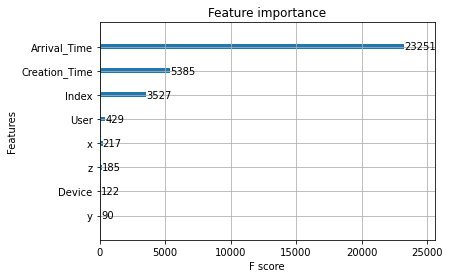

In [ ]:
import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(xgb_model, max_num_features=14) # top 10 most important features
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
print(poly.fit_transform(data_pd))
print(poly.get_feature_names_out())
print(len(poly.get_feature_names_out()))
poly_data = pd.DataFrame(poly.fit_transform(data_pd), columns=poly.get_feature_names_out())

[[ 1.42468674e+12  1.42468673e+18  1.00000000e+00 ...  7.06873782e-07
  -1.74148009e-05 -6.24661285e-06]
 [ 1.42468674e+12  1.42468673e+18  1.00000000e+00 ... -1.02900436e-04
   4.46322366e-05 -2.96337294e-04]
 [ 1.42468674e+12  1.42468673e+18  1.00000000e+00 ... -1.22996046e-04
  -7.03837705e-05  6.90792455e-04]
 ...
 [ 1.42478946e+12  1.42478946e+18  1.00000000e+00 ... -1.01538865e-01
  -5.96681383e-02  6.37344045e-02]
 [ 1.42478946e+12  1.42478946e+18  1.00000000e+00 ...  8.91808620e-01
   1.27676156e-02  6.19116456e-03]
 [ 1.42478946e+12  1.42479131e+18  2.00000000e+00 ... -2.62146646e-01
   4.07927964e-01 -5.31421774e-02]]
['Arrival_Time' 'Creation_Time' 'Device' 'Index' 'Model' 'User' 'gt' 'x'
 'y' 'z' 'Arrival_Time Creation_Time' 'Arrival_Time Device'
 'Arrival_Time Index' 'Arrival_Time Model' 'Arrival_Time User'
 'Arrival_Time gt' 'Arrival_Time x' 'Arrival_Time y' 'Arrival_Time z'
 'Creation_Time Device' 'Creation_Time Index' 'Creation_Time Model'
 'Creation_Time User' 'Creatio

Parameter optimization
[0]	validation_0-merror:0.247252	validation_1-merror:0.246585
[1]	validation_0-merror:0.253771	validation_1-merror:0.252523
[2]	validation_0-merror:0.249113	validation_1-merror:0.24879
[3]	validation_0-merror:0.232944	validation_1-merror:0.231535
[4]	validation_0-merror:0.231955	validation_1-merror:0.230329
[5]	validation_0-merror:0.228109	validation_1-merror:0.226745
[6]	validation_0-merror:0.22958	validation_1-merror:0.228343
[7]	validation_0-merror:0.229825	validation_1-merror:0.228202
[8]	validation_0-merror:0.227639	validation_1-merror:0.225905
[9]	validation_0-merror:0.228677	validation_1-merror:0.22708
[10]	validation_0-merror:0.227908	validation_1-merror:0.22624
[11]	validation_0-merror:0.226772	validation_1-merror:0.225159
[12]	validation_0-merror:0.225008	validation_1-merror:0.223462
[13]	validation_0-merror:0.225735	validation_1-merror:0.224359
[14]	validation_0-merror:0.224087	validation_1-merror:0.222601
[15]	validation_0-merror:0.222469	validation_1

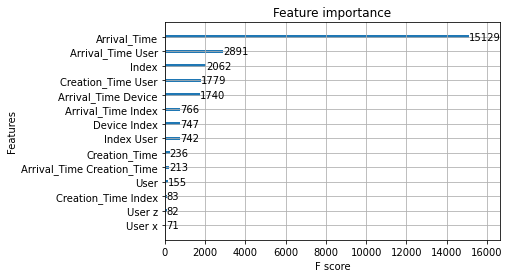

In [ ]:
X_train, X_validation = train_test_split(poly_data, train_size=0.7, random_state=0)
X_train = pd.DataFrame(X_train)
X_validation = pd.DataFrame(X_validation)
X_train, y_train = X_train.drop(labels=[col for col in X_train.columns if str(col).find("gt")!=-1], axis=1), X_train["gt"]
X_validation, y_validation = X_validation.drop(labels=[col for col in X_validation.columns if str(col).find("gt")!=-1], axis=1), X_validation["gt"]

evallist = [(X_validation, y_validation), (X_train, y_train)]

print("Parameter optimization")
params = { 
    'eta': 0.1,
    'gamma': 0.1,
    'maxDepth': 10, 
    'lambda_': 1.0,
    "n_estimators": 1000,
    'subsample': 1.0,
    'numRound': 100,
    'numWorkers': 1,
    'verbosity': 1
}
xgb_model = xgb.XGBClassifier(**params)

xgb_model.fit(X=X_train, 
              y=y_train, 
              eval_set=evallist,
              early_stopping_rounds=10)  # merror = 1 - accuracy

plot_importance(xgb_model, max_num_features=14) # top 10 most important features
plt.show()

In [ ]:
xgb_model.feature_importances_

array([0.05268458, 0.00998434, 0.00945802, 0.08155405, 0.        ,
       0.04686033, 0.0134109 , 0.00784575, 0.00904694, 0.01885984,
       0.00291689, 0.16654849, 0.        , 0.008858  , 0.02953519,
       0.01867567, 0.03194933, 0.01048754, 0.10777926, 0.        ,
       0.01064978, 0.05821737, 0.00670422, 0.        , 0.00498638,
       0.        , 0.01101717, 0.00240076, 0.00589516, 0.01581816,
       0.        , 0.01174534, 0.03120974, 0.01312835, 0.02842448,
       0.        , 0.        , 0.        , 0.        , 0.03983697,
       0.00866731, 0.0232415 , 0.0222871 , 0.04596944, 0.03334566],
      dtype=float32)

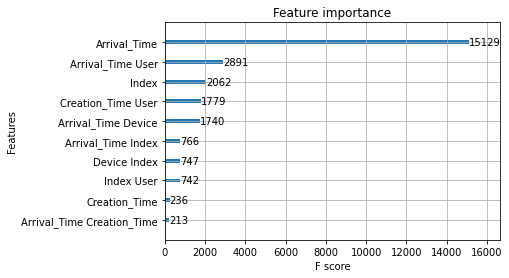

In [ ]:
import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(xgb_model, max_num_features=10)
plt.show()

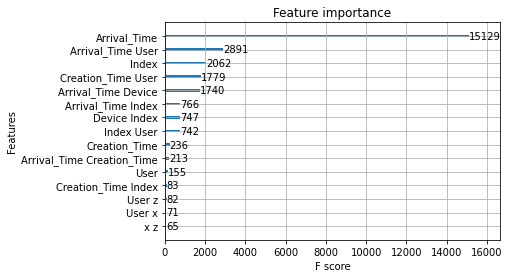

In [ ]:
plot_importance(xgb_model, max_num_features=15)
plt.show()

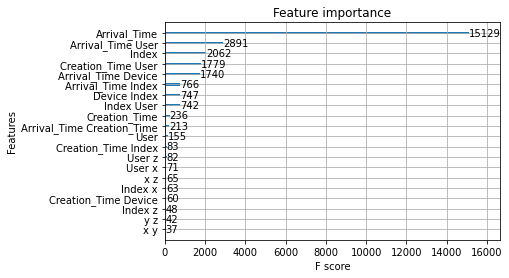

In [ ]:
plot_importance(xgb_model, max_num_features=20)
plt.show()

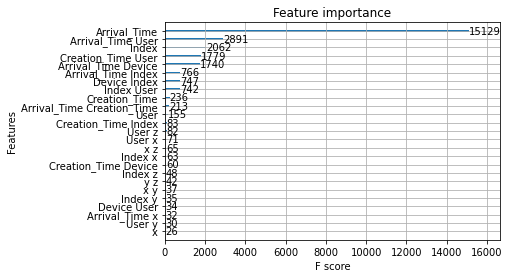

In [ ]:
plot_importance(xgb_model, max_num_features=25)
plt.show()

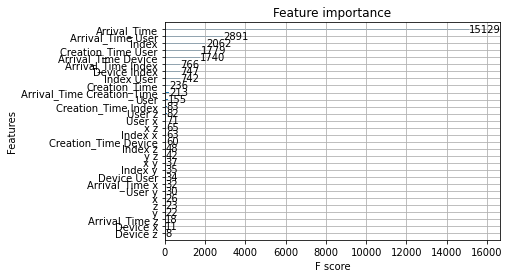

In [ ]:
plot_importance(xgb_model, max_num_features=30)
plt.show()

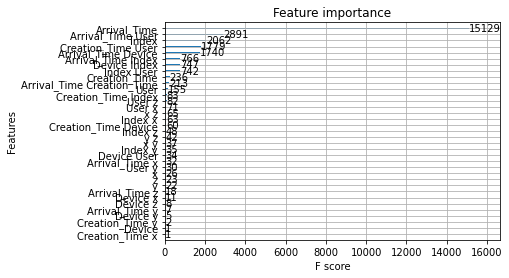

In [ ]:
plot_importance(xgb_model, max_num_features=35)
plt.show()

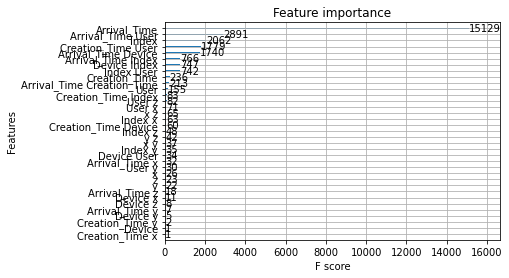

In [ ]:
plot_importance(xgb_model, max_num_features=40)
plt.show()

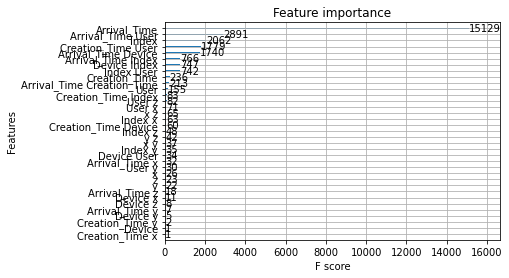

In [ ]:
plot_importance(xgb_model, max_num_features=45)
plt.show()

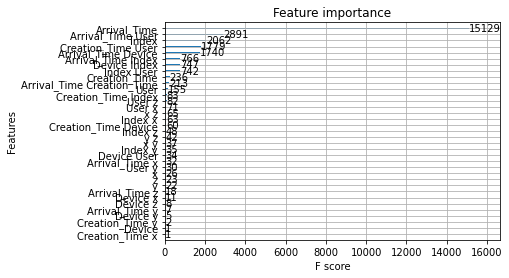

In [ ]:
plot_importance(xgb_model, max_num_features=50)
plt.show()

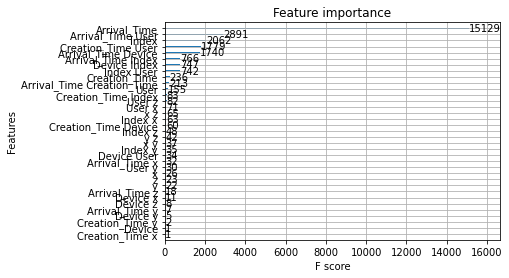

In [ ]:
plot_importance(xgb_model, max_num_features=55)
plt.show()

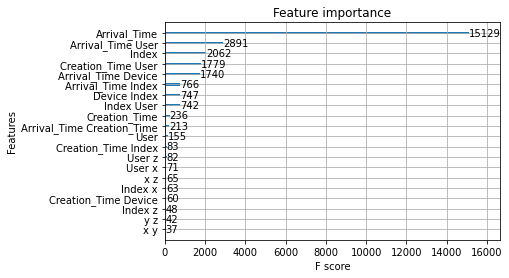

In [ ]:
plot_importance(xgb_model, max_num_features=20, importance_type="weight")
plt.show()

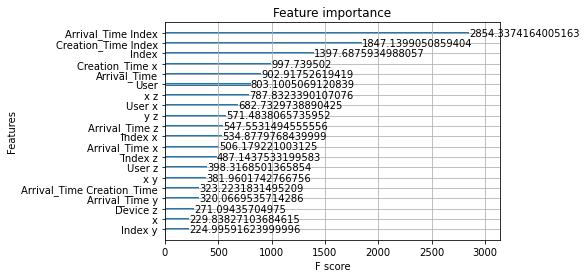

In [ ]:
plot_importance(xgb_model, max_num_features=20, importance_type="gain")
plt.show()

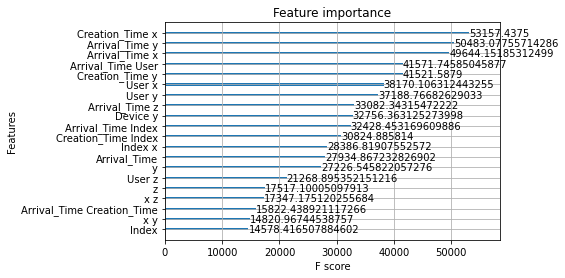

In [ ]:
plot_importance(xgb_model, max_num_features=20, importance_type="cover")
plt.show()

In [ ]:
y_pred = xgb_model.predict(X_validation)

In [ ]:
sum(y_pred==y_validation) / len(y_pred)

0.9063146650389134